In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, LightCurve, SNSurvey

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [4]:
%%time
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

survey = SNSurvey(model=model, area=5, cadence=1)
survey.simulate(bandpasses, norm=10, Ncpus=8)

print(survey)

SN Survey Simulation: 

    N obs = 3040  
     zmin = 0     
     zmax = 1     
     area = 5     
 duration = 1000.0
  cadence = 1     
flux errf = 0.05  

Model: 
source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 2.0
  phases     : [-20, .., 50] days
  wavelengths: [1700, .., 24990] Angstroms
parameters:
  z  = 0.0
  t0 = 0.0
  x0 = 1e-05
  x1 = 0.1
  c  = -0.1
CPU times: user 3.84 s, sys: 478 ms, total: 4.32 s
Wall time: 19.3 s


Print the first observation as an example:

In [5]:
print(survey.obs[0])

SkyObject Observation: 

     source = SN1a  
         t0 = 59869.384
     spec-z = 0.9029
    photo-z = None  
photo-z err = None  
      N obs = 70    

   mjd     filter   flux   flux_err
---------- ------ -------- --------
59850.0064  lssty 0.005359 0.000284
59851.2897  lsstu 0.003873 0.000222
59852.0944  lsstg 0.047026 0.002324
59853.1661  lsstr 0.001035    5e-05
59853.8322  lssti 0.282728 0.013537
 59854.925  lsstz 0.530661   0.0276
       ...    ...      ...      ...
59913.9407  lssti 0.363918 0.017253
59915.1411  lsstz 0.379825  0.01912
59915.8539  lssty 0.388235 0.020105
59916.9673  lsstu 0.001051    5e-05
59918.2928  lsstg 0.068084 0.003321
59918.9845  lsstr 0.065938 0.003343
Length = 70 rows


Plot the flux of the SALT2 model the survey is simulated from

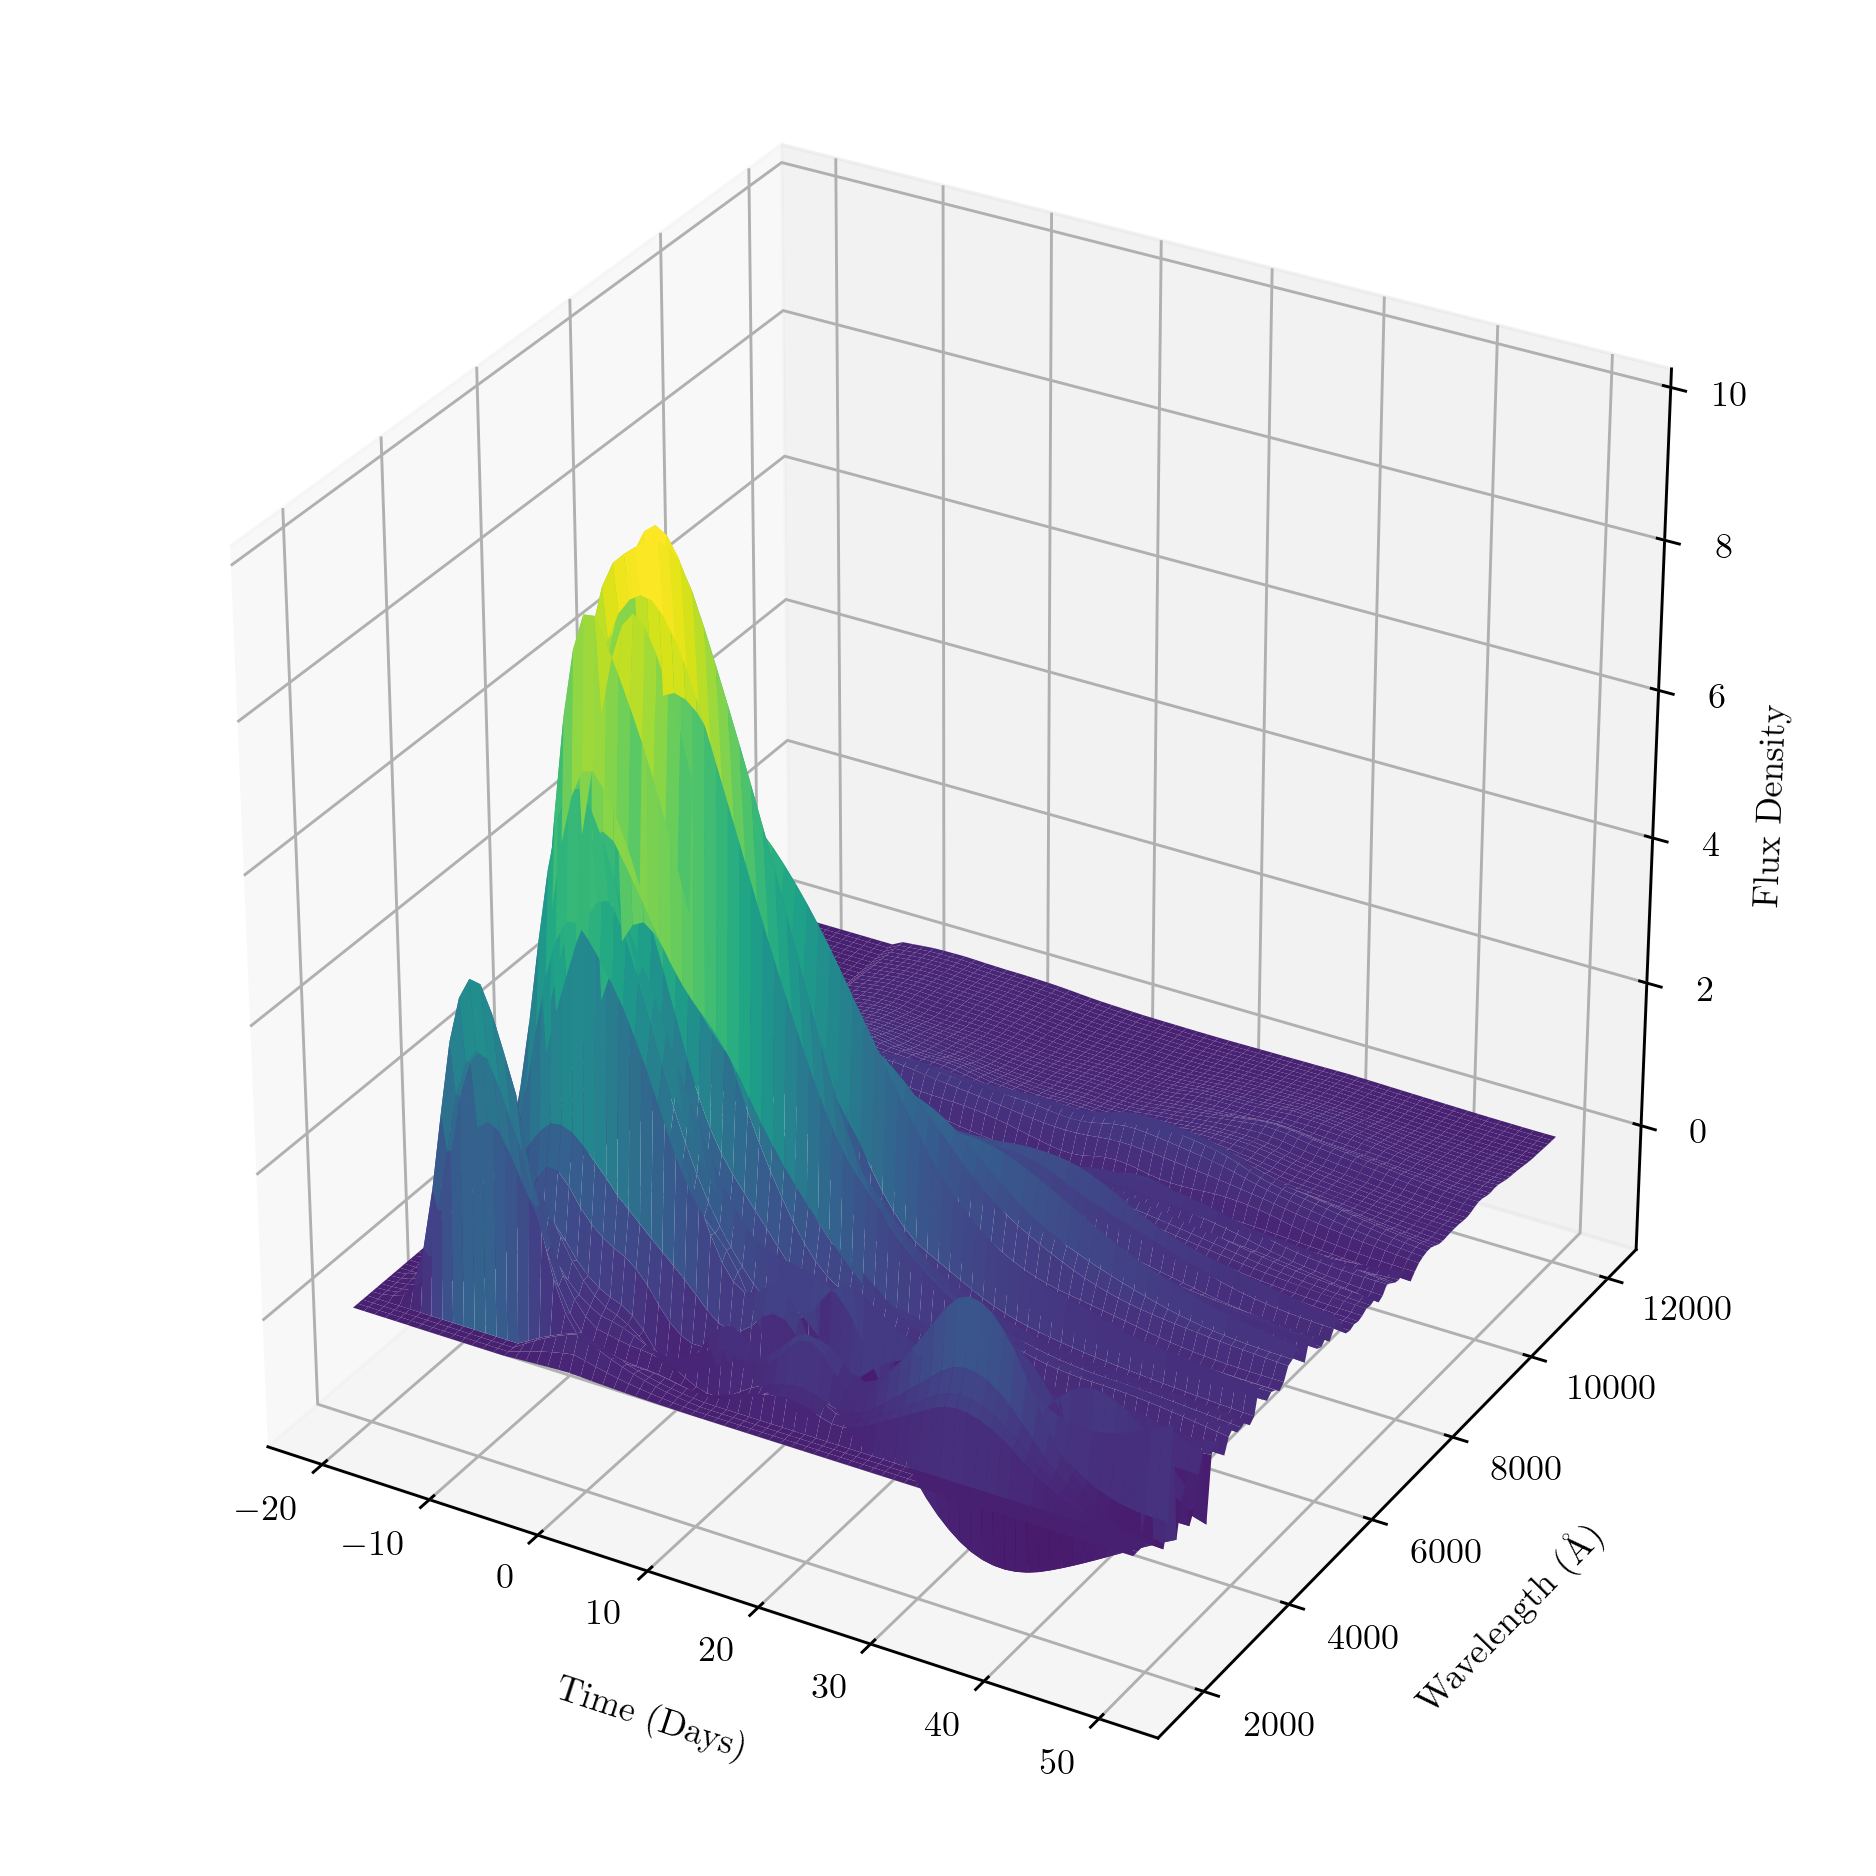

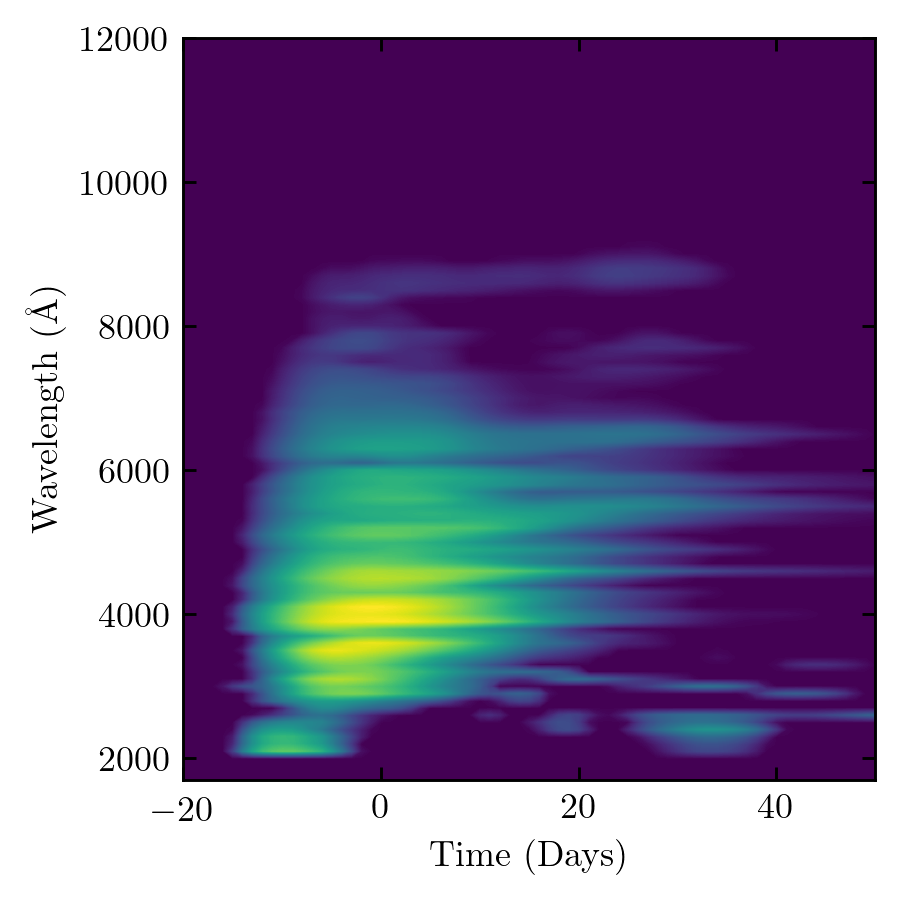

In [6]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lc = LightCurve(time, wavelen)
lc.from_model(model)
fig = lc.surface_plot()
fig = lc.contour_plot()

Now we start with a totally null light curve

In [7]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lcn = LightCurve(time, wavelen)
lcn.null()

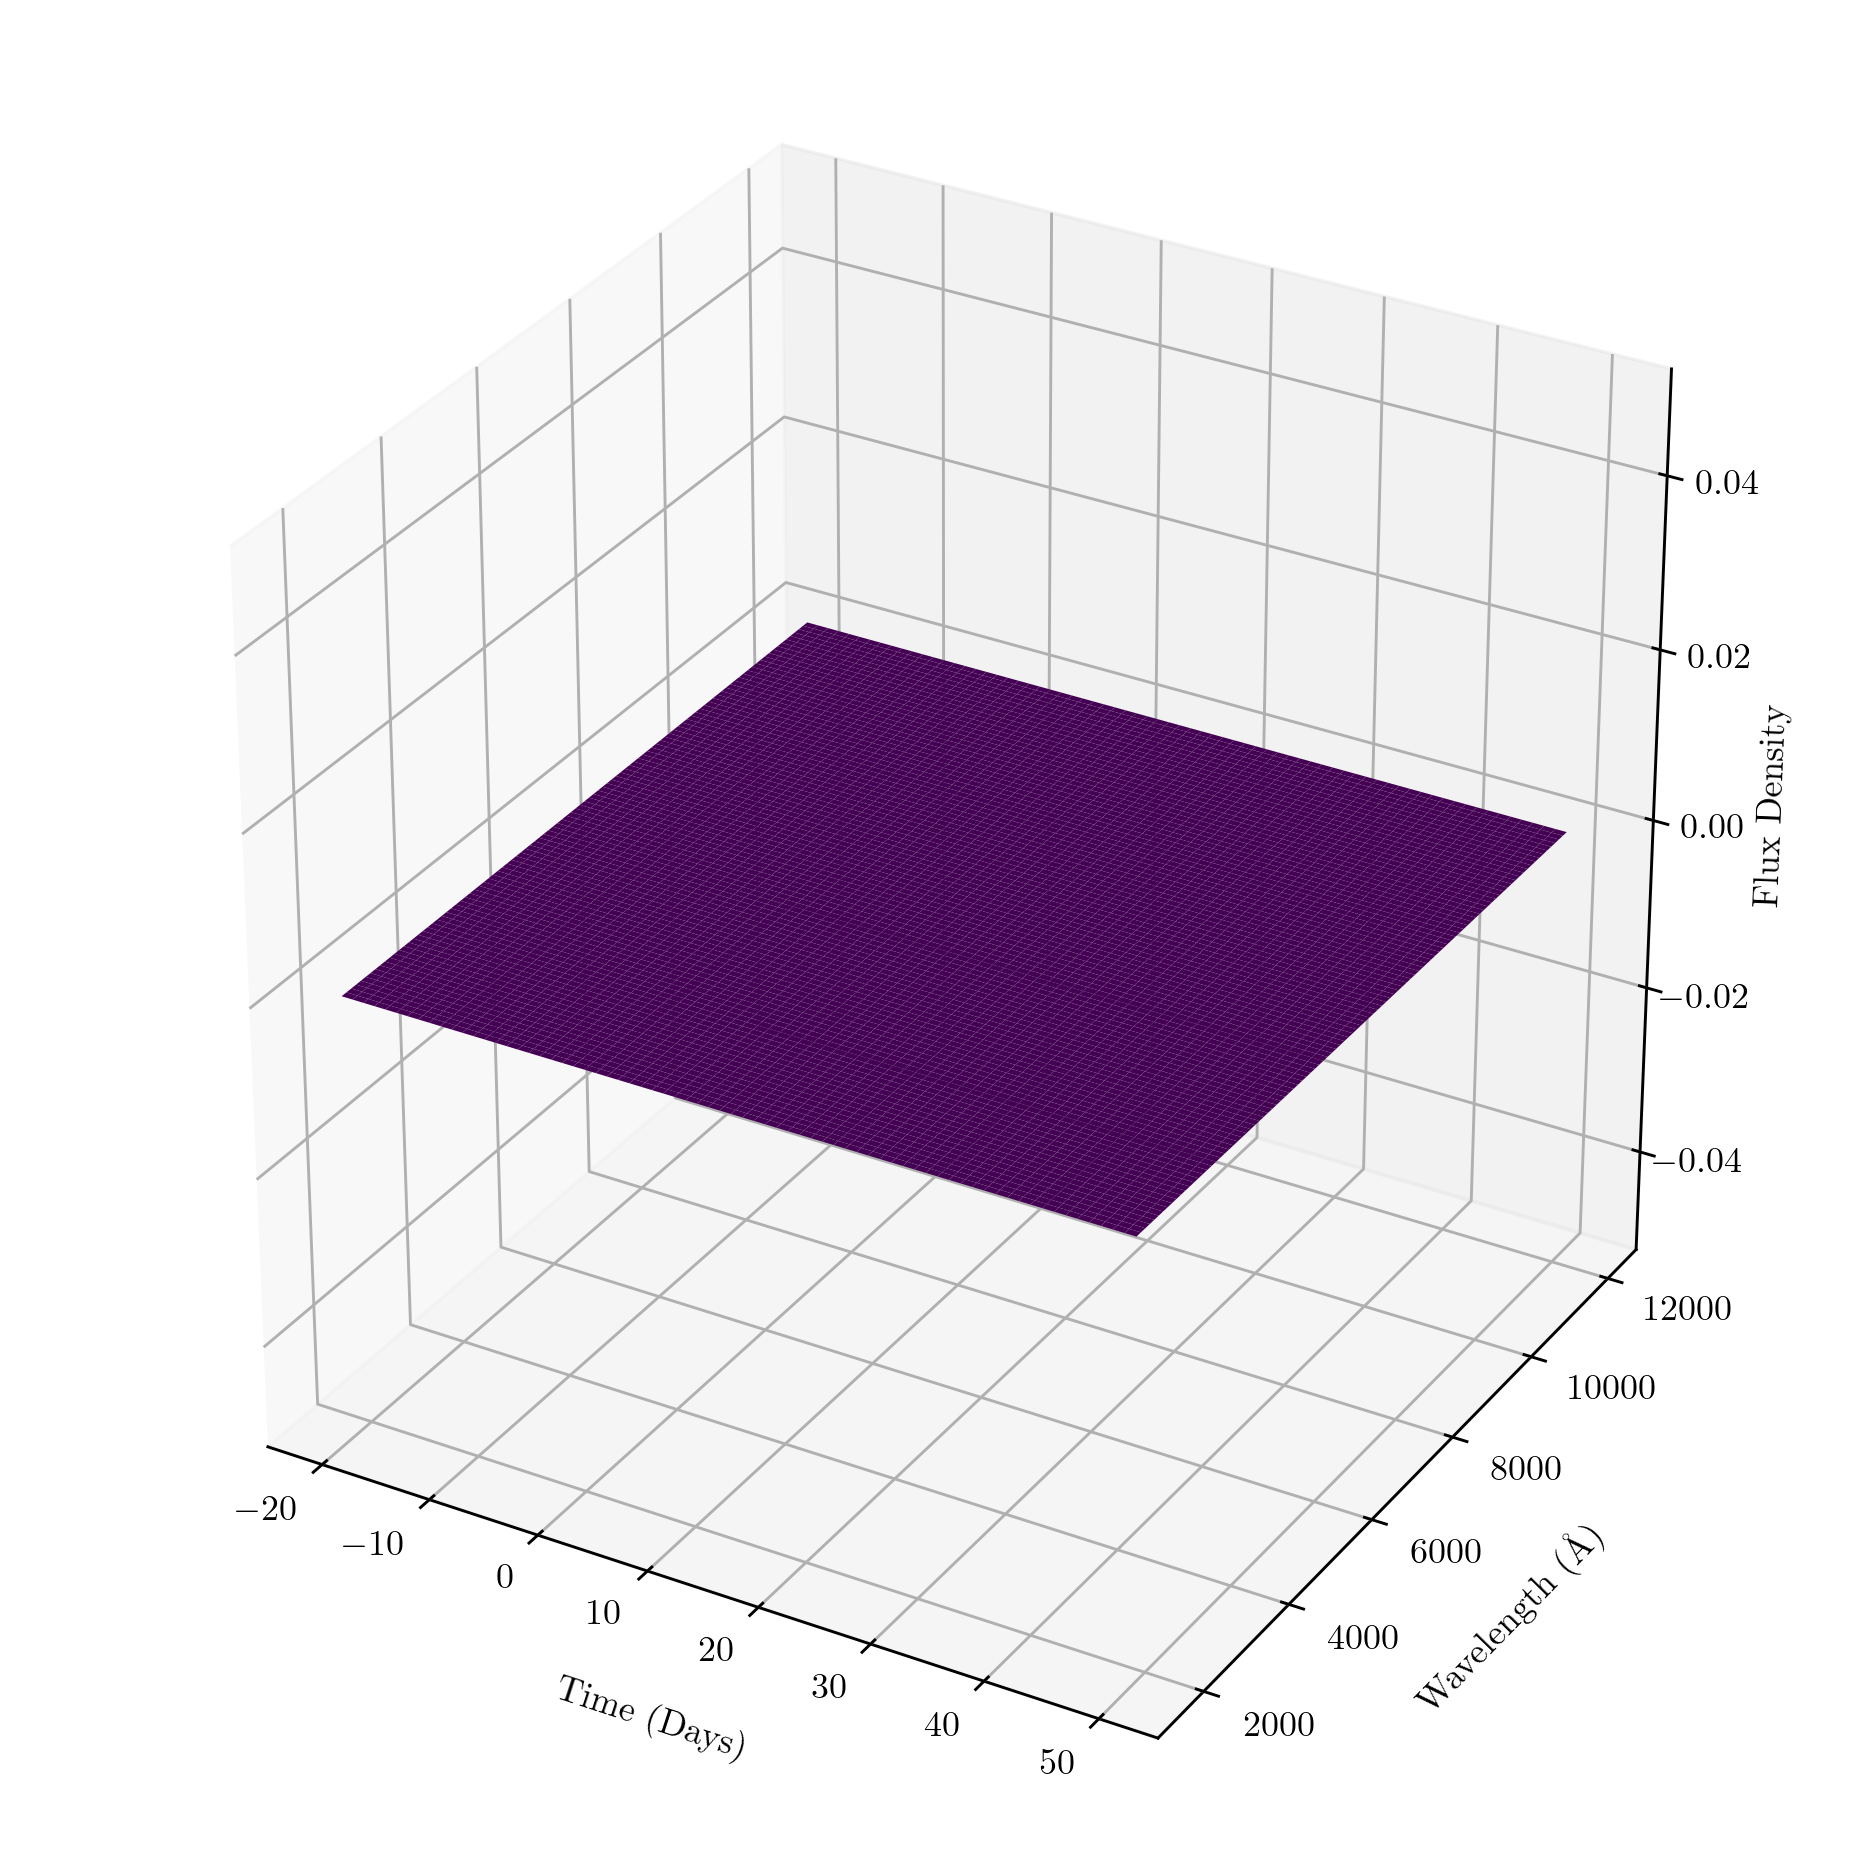

In [8]:
fig = lcn.surface_plot()

Let's make the time-slice training sets:

In [9]:
%time training_sets = lcn.training_sets(survey.obs)

CPU times: user 1min 25s, sys: 663 ms, total: 1min 25s
Wall time: 1min 25s


Before we start training, let's evaluate the weighted mean square error.

A perfect score is:

In [10]:
%time lc.mse(training_sets, bandpasses, Ncpus=4)

CPU times: user 27 s, sys: 1.55 s, total: 28.6 s
Wall time: 44.6 s


6.7338640499127385

Our null light curve currently has a score of

In [11]:
%time lcn.mse(training_sets, bandpasses, Ncpus=4)

CPU times: user 27.4 s, sys: 1.17 s, total: 28.5 s
Wall time: 51.9 s


1982.5357596105623

Now train the light curve on the photometry in the simulated survey

In [12]:
%time lcn.train(training_sets, bandpasses, w=0.01, dmse_stop=0.01, Ncpus=4)

CPU times: user 23.5 s, sys: 1.31 s, total: 24.8 s
Wall time: 2min 29s


After training, the wMSE is

In [13]:
lcn.mse(training_sets, bandpasses, Ncpus=3)

6.176395866624374

Now plot the results!

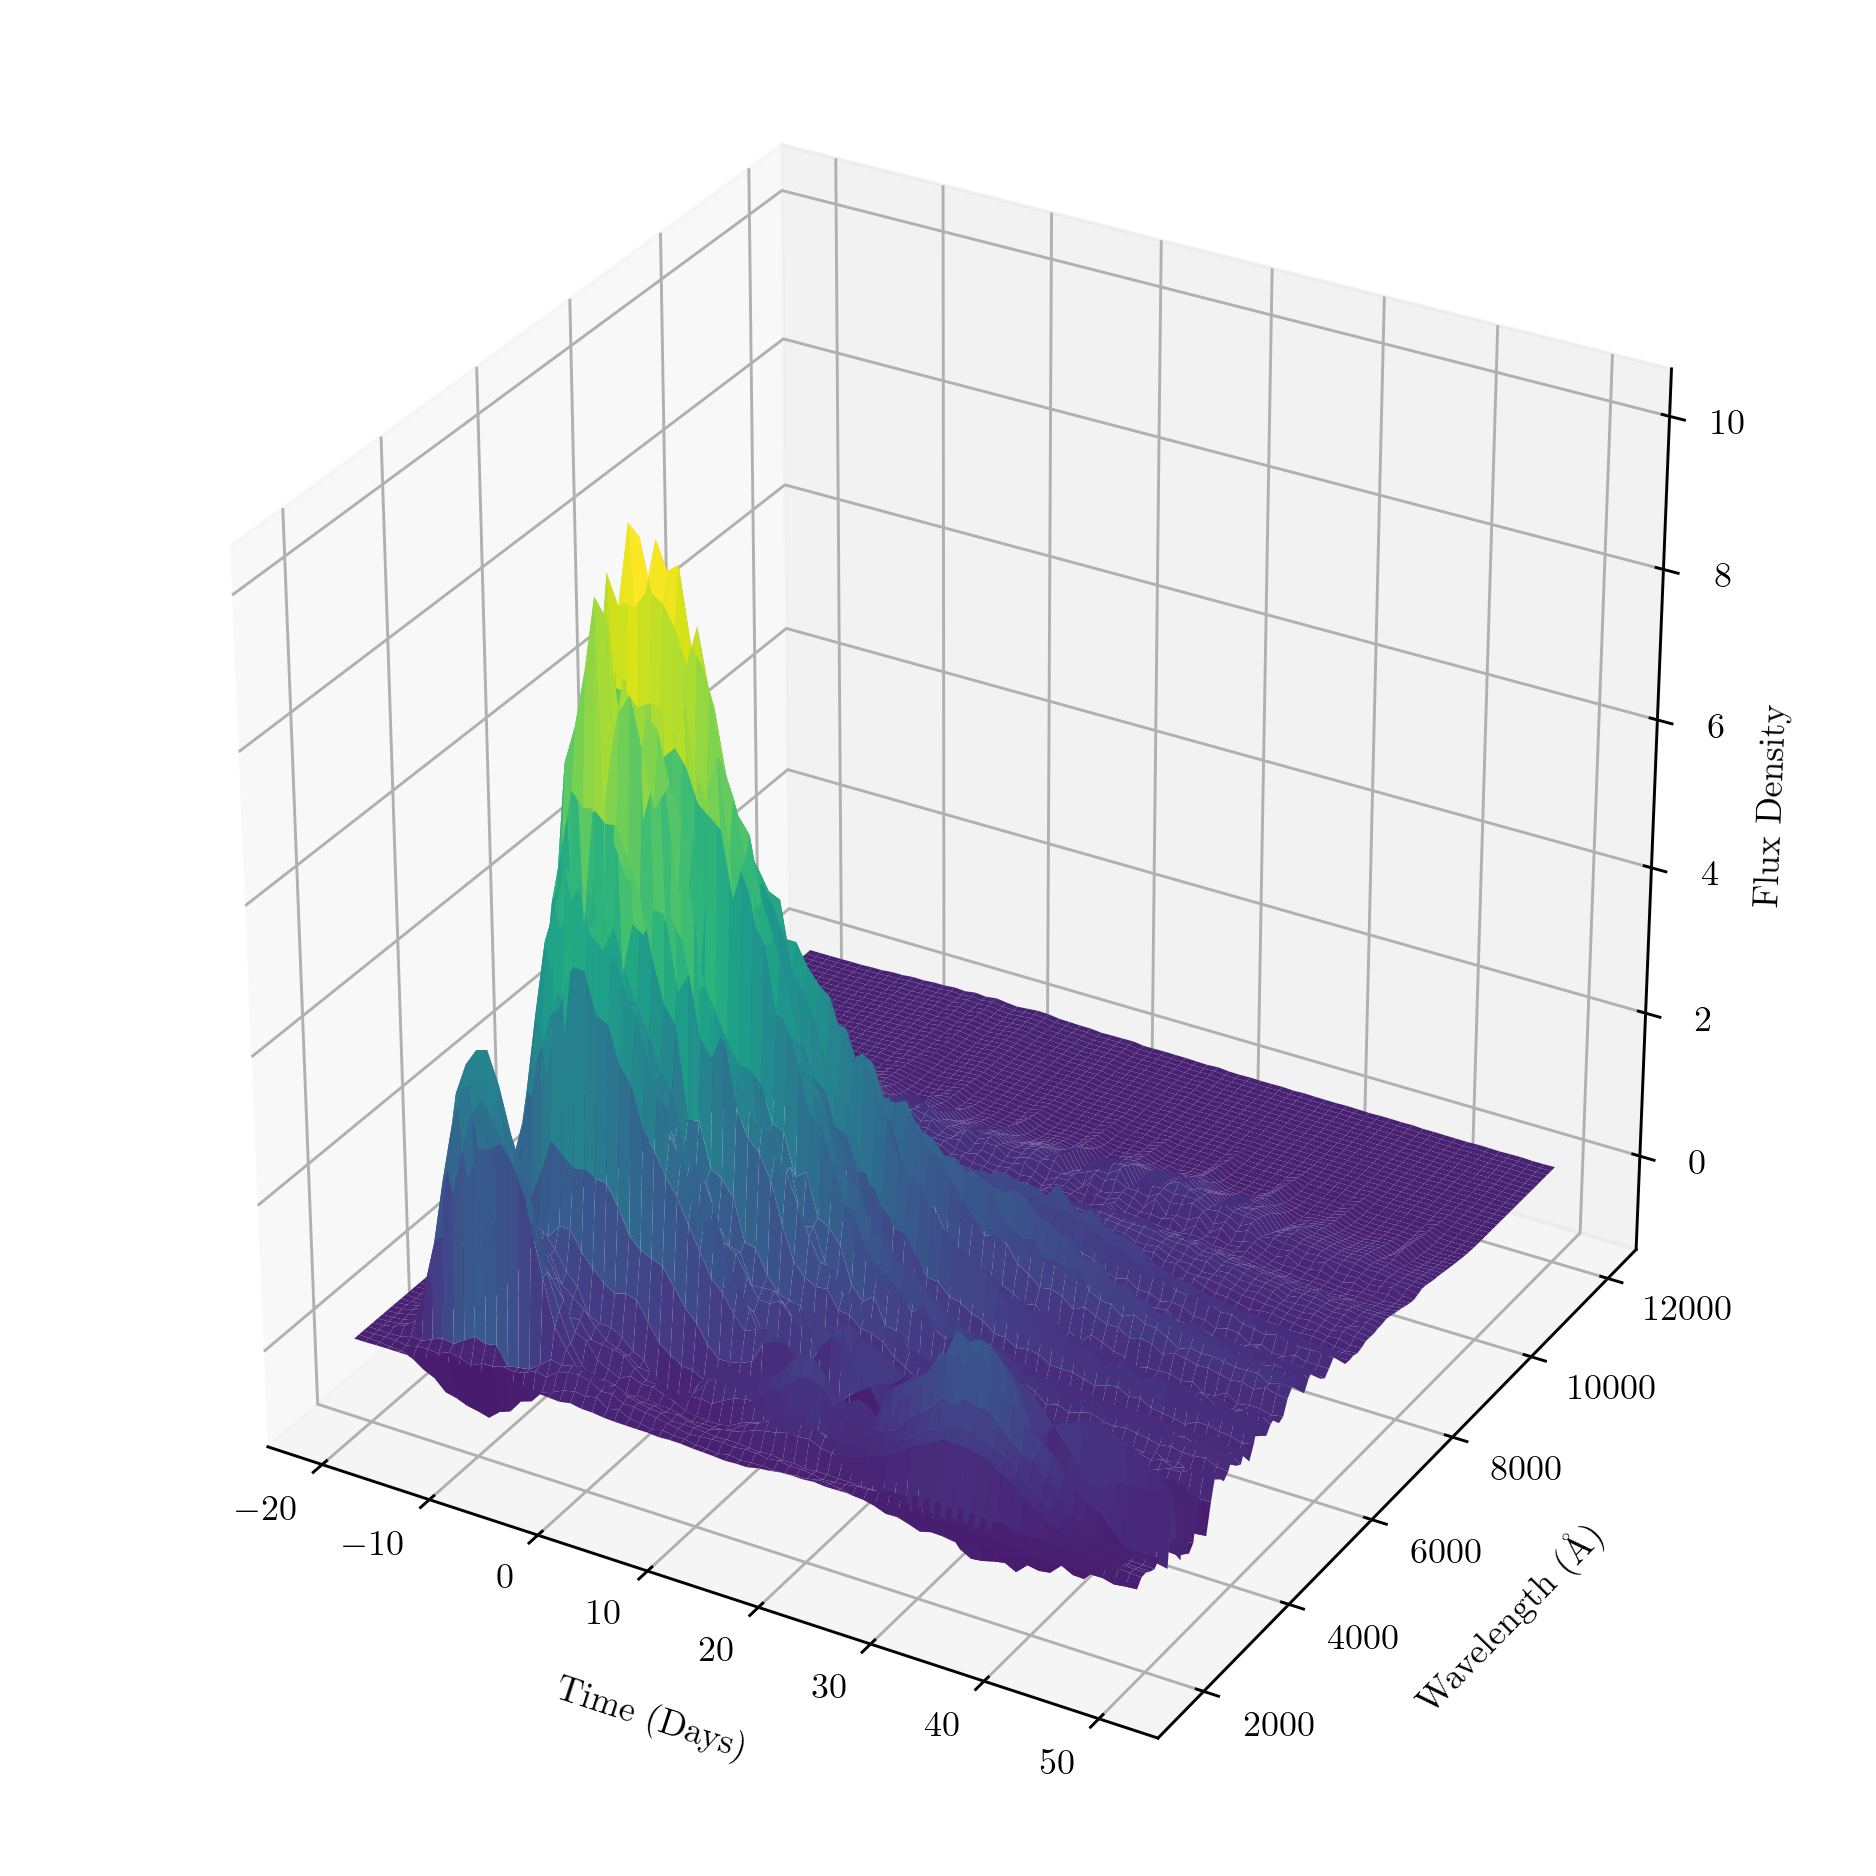

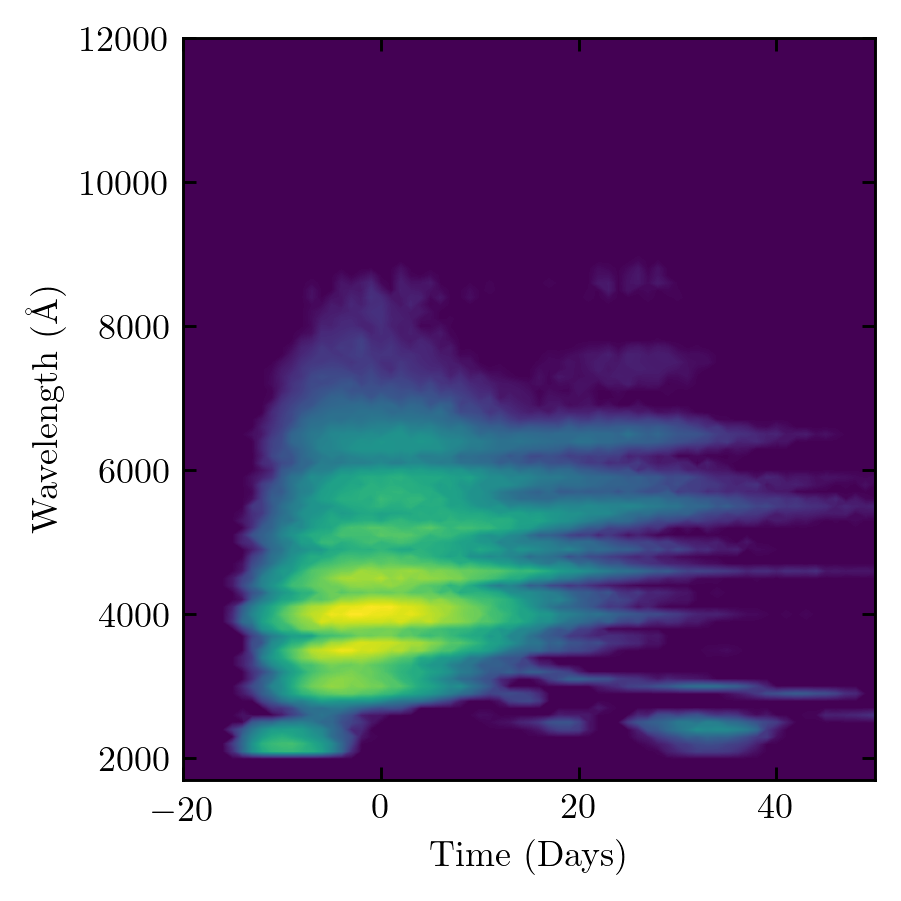

In [14]:
fig = lcn.surface_plot()
fig = lcn.contour_plot()

Now I will make comparison plots. I plot the surfaces and contours side by side, and make a plot of the residuals.

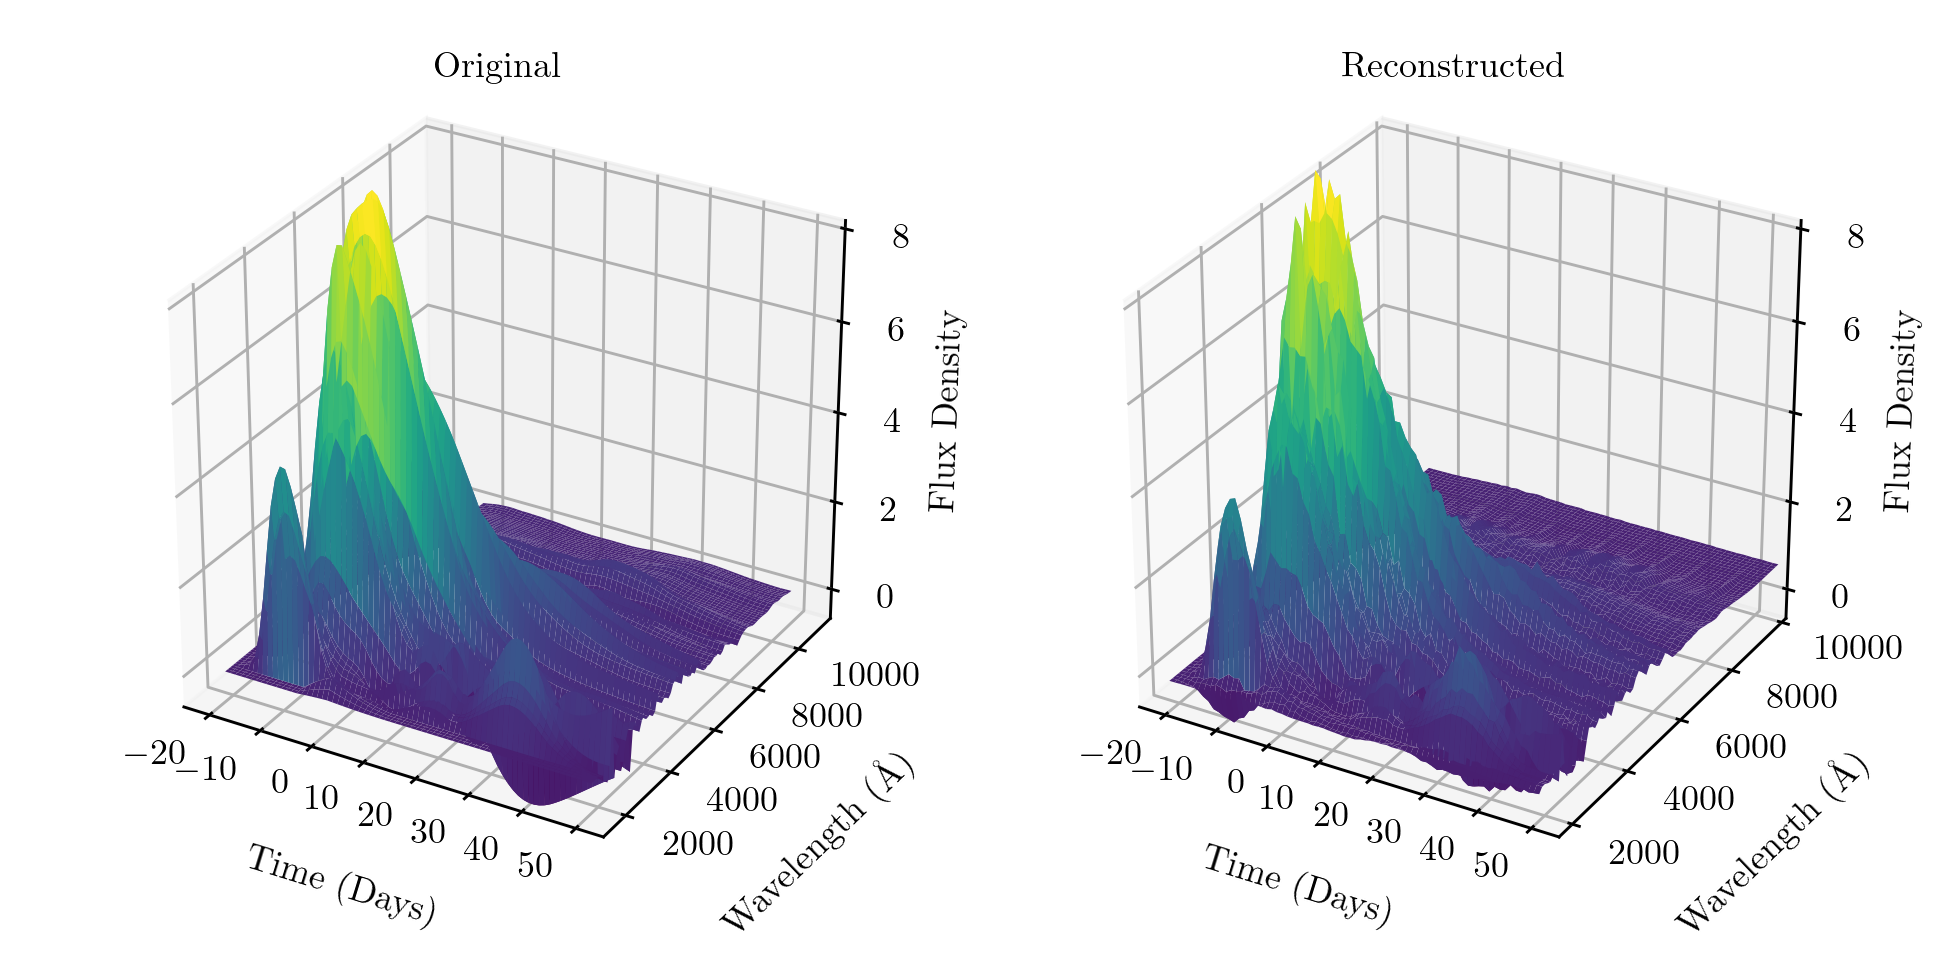

In [15]:
fig = plt.figure(figsize=(twocol,onecol))

ymax = 11000
idx = np.abs(lc.wavelen - ymax).argmin()
x, y = np.meshgrid(lc.time, lc.wavelen[:idx])

ax = fig.add_subplot(1,2,1, projection='3d')
ax.dist = 11

ax.plot_surface(x, y, lc.flux(lc.time,lc.wavelen[:idx]), cmap='viridis', rcount=200, ccount=200)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Time (Days)", ha='left')
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Original")

ax = fig.add_subplot(1,2,2, projection='3d')
ax.dist = 11
ax.plot_surface(x, y, lcn.flux(lcn.time,lcn.wavelen[:idx]), cmap='viridis', rcount=200, ccount=200)
ax.set_ylim(1700,10000)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Reconstructed")

plt.subplots_adjust(wspace=0.01,top=1.07,bottom=0.03,left=-0.04,right=0.99)
fig.savefig('plots/surface_comparison.png')

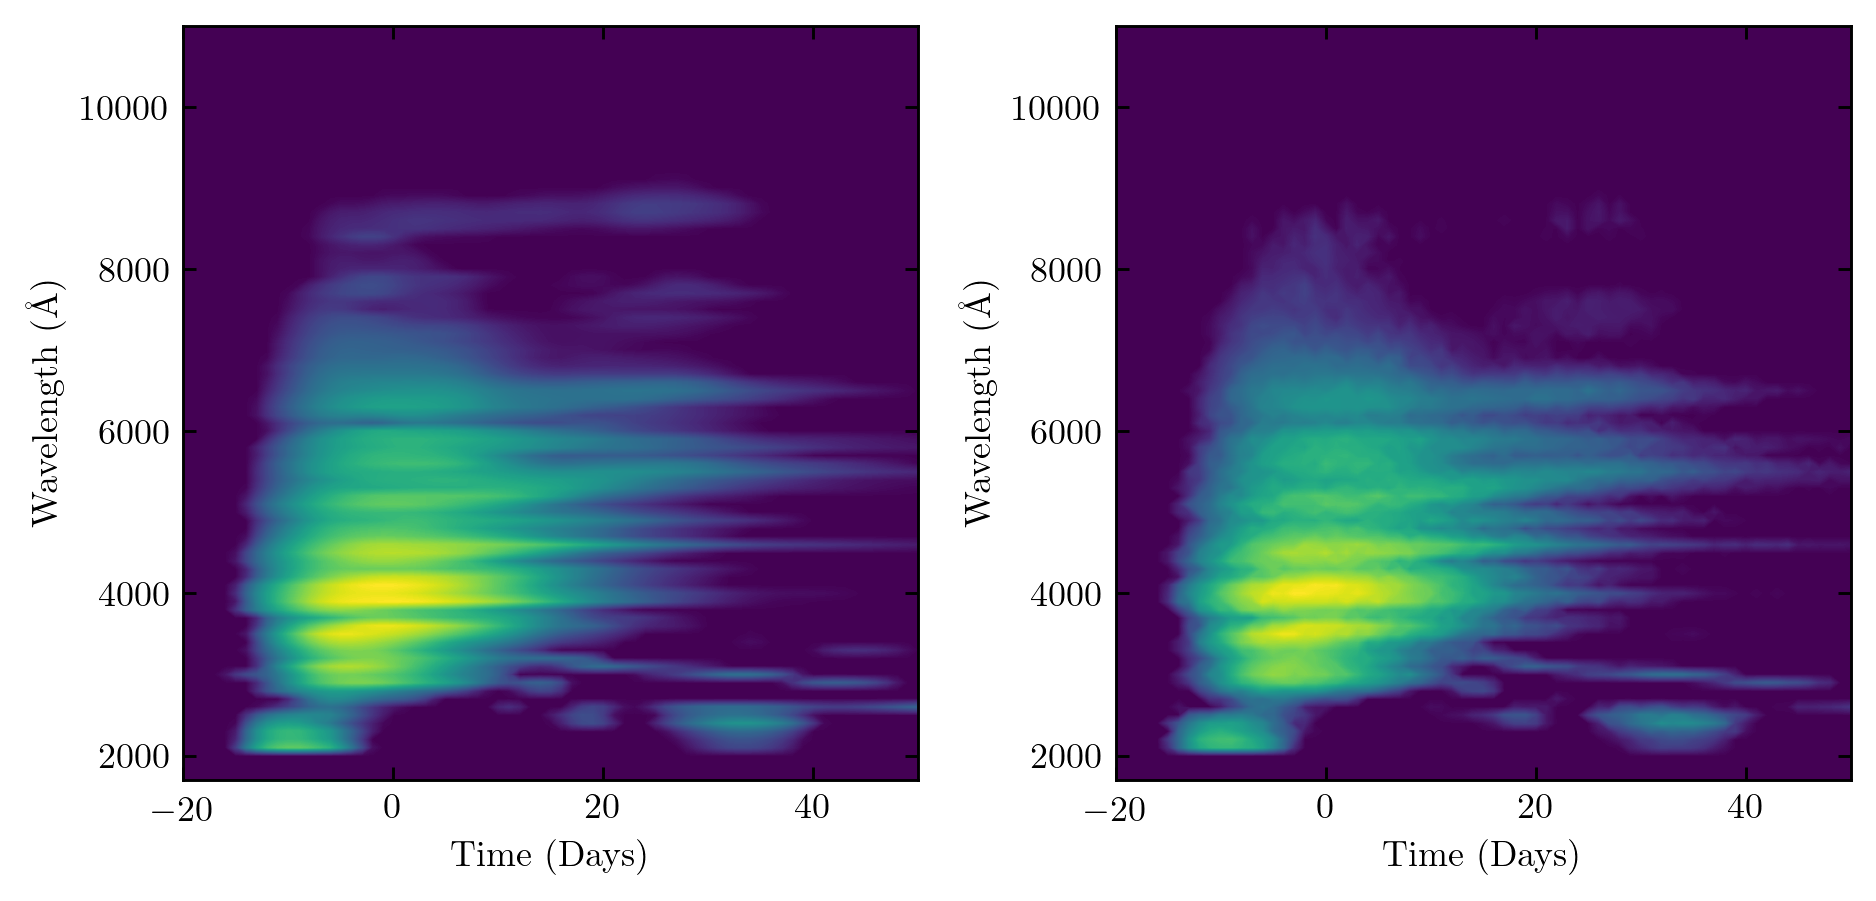

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(twocol,onecol),constrained_layout=True)

x,y = np.meshgrid(lc.time, lc.wavelen)

zcut = np.max(lc.flambda)/20
z = np.log10( np.clip(lc.flambda, zcut, None) )
ax1.contourf(x, y, z, levels=200)
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylim(1700,11000)

zcut = np.max(lcn.flambda)/20
z = np.log10( np.clip(lcn.flambda, zcut, None) )
ax2.contourf(x, y, z, levels=200)
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax2.set_ylim(1700,11000)

fig.savefig('plots/contour_comparison.png')

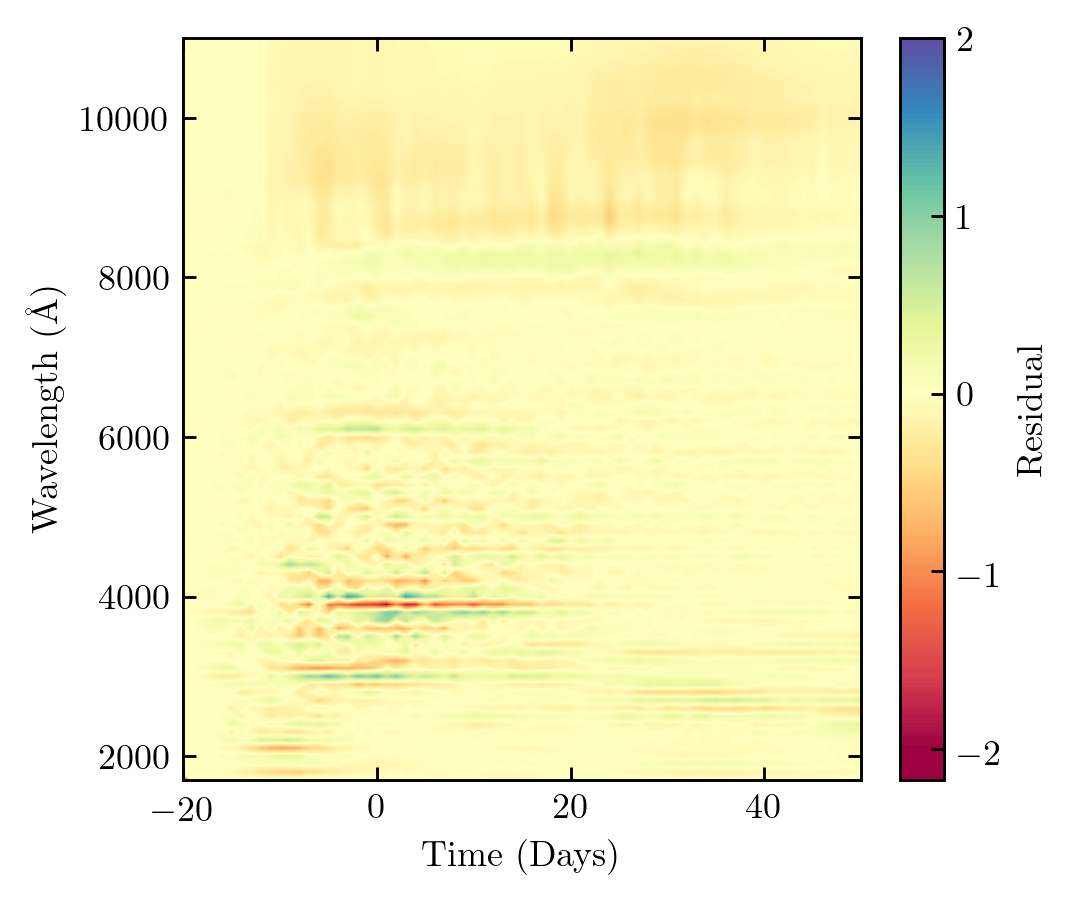

In [53]:
fig,ax = plt.subplots(figsize=(1.2*onecol,onecol), constrained_layout=True)

z = (lcn.flambda - lc.flambda)
zmax = 2
z[0,0], z[-1,-1] = -zmax, zmax
cont = ax.contourf(lc.time, lc.wavelen, z, cmap='Spectral', vmin=-zmax, vmax=zmax, levels=200)
fig.colorbar(cont, ticks=[-2,-1,0,1,2], label='Residual')
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax.set_ylim(1700,11000)

fig.savefig('plots/residuals.png')
plt.show()